# Principal Component Analysis - Key Ideas

PCA finds principal components as linear combinations of the existing features and uses these components to represent the original data. The number of components is a hyperparameter that determines the target dimensionality and needs to be equal to or smaller than the number of observations or columns, whichever is smaller. 

PCA aims to capture most of the variance in the data, to make it easy to recover the original features, and that each component adds information. It reduces dimensionality by projecting the original data into the principal component space. 

## Imports & Settings

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from numpy.linalg import lstsq
from numpy.random import randn, seed
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
# plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')
pd.options.display.float_format = '{:,.2f}'.format
seed(42)

## Linear Projection: Principal Component Analysis

The PCA algorithm works by identifying a sequence of principal components, each of which aligns with the direction of maximum variance in the data after accounting for variation captured by previously computed components. The sequential optimization also ensures that new components are not correlated with existing components so that the resulting set constitutes an orthogonal basis for a vector space.

This new basis corresponds to a rotated version of the original basis so that the new axes point in the direction of successively decreasing variance. The decline in the amount of variance of the original data explained by each principal component reflects the extent of correlation among the original features. The number of components that captures, e.g., 95% of the original variation relative to the total number of features provides insights into the linearly independent information in the original data.

The below figures illustrates several aspects of PCA for a two-dimensional random data set.

### Create Noisy, Correlated Data from Signal

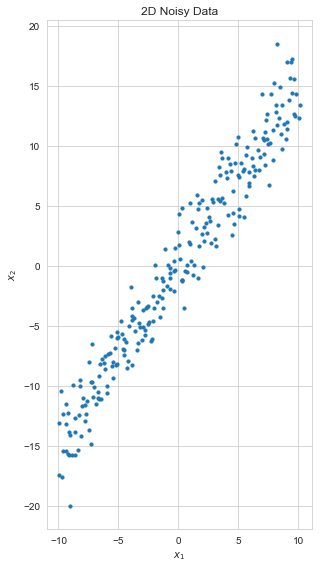

In [3]:
n_signals = 250
x1 = np.linspace(-10, 10, n_signals) + .1 * randn(n_signals)
x2 = 1.5 * x1 + 2 * randn(n_signals)
data = pd.DataFrame({'$x_1$': x1, '$x_2$': x2})
ax = data.plot.scatter(x=0, y=1, s=10, title='2D Noisy Data', figsize=(7,8))
ax.set_aspect('equal')
plt.tight_layout()

### Compute Principal Components 

In [4]:
pca = PCA()
pca.fit(data)
pca.components_

array([[-0.54381787, -0.83920327],
       [ 0.83920327, -0.54381787]])

In [5]:
mean = pca.mean_
mean

array([-0.00024229,  0.03183435])

In [6]:
pc1, pc2 = np.split(pca.components_.T, 2, axis=1)
pc1

array([[-0.54381787],
       [-0.83920327]])

#### Check share of explained variance

In [7]:
pca.explained_variance_ratio_

array([0.98929523, 0.01070477])

### Components are orthogonal to each other

In [8]:
np.dot(pc1.T, pc2)

array([[0.]])

### Plot Principal Components as new Basis Vectors

The below figure shows how the first and second principal components align with the directions of maximum variance while being orthogonal.

In [9]:
l1, l2 = pca.singular_values_ / 10

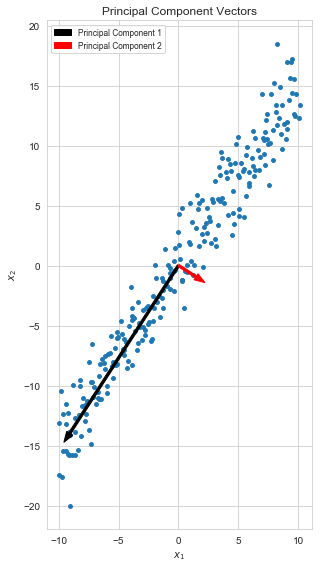

In [10]:
ax = data.plot.scatter(x=0, y=1, s=15, title='Principal Component Vectors', figsize=(6,8))
ax.set_aspect('equal')
origin_x, origin_y = pca.mean_
dx1, dy1 = np.squeeze(pc1.T) * l1
dx2, dy2 = np.squeeze(pc2.T) * l2
pc1_arrow = ax.arrow(origin_x, origin_y, dx1, dy1,  width=.2, color='k')
pc2_arrow = ax.arrow(origin_x, origin_y, dx2, dy2,  width=.2, color='r')
plt.legend([pc1_arrow, pc2_arrow], 
           ['Principal Component 1', 'Principal Component 2'], 
           fontsize='small')
plt.tight_layout()

### Project 2D data onto the first Principal Component

The following figure demonstrates how the first principal component minimizes the reconstruction error, measured as the sum of the distances between the data points and the new axis.

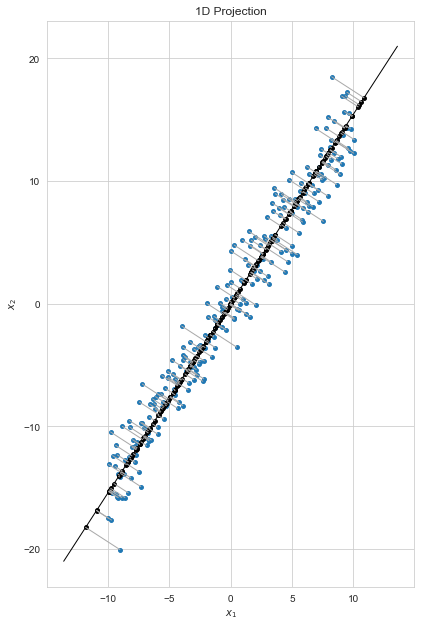

In [11]:
# de-mean data, convert to numpy array
data_ = data.sub(data.mean())
X_ = data_.values
x_, y_ = X_.T
ax = pd.DataFrame({'$x_1$': x_, '$x_2$': y_}).plot.scatter(x='$x_1$', 
                                                           y='$x_2$', 
                                                           s=15, 
                                                           title='1D Projection', 
                                                           figsize=(6, 12))
ax.set_aspect('equal')

# plot first component
t = np.linspace(-25, 25, n_signals)
pc_x, pc_y = t * pc1
ax.plot(pc_x, pc_y, c='k', lw=1)

# project original data on first component
proj_x, proj_y = (X_.dot(pc1) * pc1.T).T
ax.scatter(proj_x, proj_y, s=15, c='k')

# plot link from data to projected points
lines_x, lines_y = np.c_[x_, proj_x], np.c_[y_, proj_y]
ax.plot(lines_x.T, lines_y.T, lw=1, c='darkgrey')
plt.tight_layout()

### Plot 1D Representation 

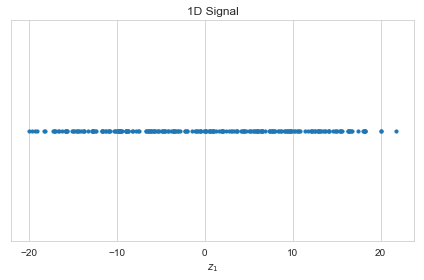

In [12]:
projection1D = data_.dot(pc1)
ax = projection1D.rename(columns={0: '$z_1$'})\
    .assign(x2=0).plot.scatter(x='$z_1$', y='x2', s=10, title='1D Signal')
ax.get_yaxis().set_visible(False)
plt.tight_layout();

### Compare to Linear Regression

Finally, the below figure contrasts PCA with supervised OLS, which approximates the outcome variable (here we choose x2) by a (one-dimensional) hyperplane computed from the (single) feature. 

The vertical lines highlight how OLS minimizes the distance along the outcome axis, in contrast with PCA that minimizes the distances orthogonal to the hyperplane.

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # Remove the CWD from sys.path while we load stuff.


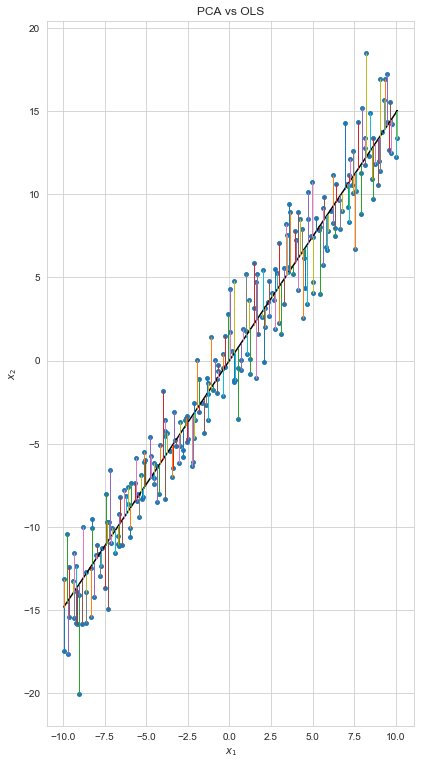

In [13]:
ax = pd.DataFrame({'$x_1$': x_, '$x_2$': y_}).plot.scatter(x='$x_1$', 
                                                           y='$x_2$', 
                                                           s=15, 
                                                           title='PCA vs OLS', 
                                                           figsize=(6, 12))
ax.set_aspect('equal')

# get OLS line
reg_X = np.column_stack((x_, np.ones_like(x_)))
(m, b), _, _, _ = lstsq(reg_X, y_)
reg_y = m * x_ + b
ax.plot(x_, reg_y, c='k')

# plot residuals
lines_x, lines_y = np.c_[x_, x_], np.c_[y_, reg_y]
ax.plot(lines_x.T, lines_y.T, lw=1)
plt.tight_layout()

## Combined Figure

The below figure is included in the book.

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.7/site-packages/ipykernel_launcher.py:49: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


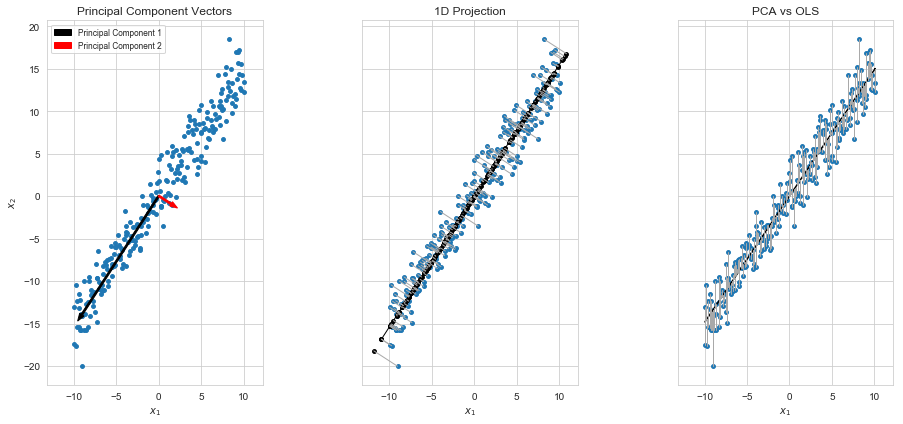

In [15]:
fig, axes = plt.subplots(ncols=3, figsize=(14, 6), sharex=True, sharey=True)

title='Principal Component Vectors'
data.plot.scatter(x=0, y=1, s=15, ax=axes[0], title=title)
axes[0].set_aspect('equal')

origin_x, origin_y = pca.mean_
dx1, dy1 = np.squeeze(pc1.T) * l1
dx2, dy2 = np.squeeze(pc2.T) * l2
pc1_arrow = axes[0].arrow(origin_x, origin_y, dx1, dy1,  width=.2, color='k')
pc2_arrow = axes[0].arrow(origin_x, origin_y, dx2, dy2,  width=.2, color='r')
axes[0].legend([pc1_arrow, pc2_arrow],
               ['Principal Component 1', 'Principal Component 2'],
               fontsize='small')

# de-mean data, convert to numpy array
data_ = data.sub(data.mean())
X_ = data_.values
x_, y_ = X_.T
pd.DataFrame({'$x_1$': x_, '$x_2$': y_}).plot.scatter(x='$x_1$',
                                                      y='$x_2$',
                                                      s=15,
                                                      title='1D Projection',
                                                      ax=axes[1])
axes[1].set_aspect('equal')

# plot first component
t = np.linspace(-20, 20, n_signals)
pc_x, pc_y = t * pc1
axes[1].plot(pc_x, pc_y, c='k', lw=1)

# project original data on first component
proj_x, proj_y = (X_.dot(pc1) * pc1.T).T
axes[1].scatter(proj_x, proj_y, s=15, c='k')

# plot link from data to projected points
lines_x, lines_y = np.c_[x_, proj_x], np.c_[y_, proj_y]
axes[1].plot(lines_x.T, lines_y.T, lw=1, c='darkgrey')

pd.DataFrame({'$x_1$': x_, '$x_2$': y_}).plot.scatter(x='$x_1$',
                                                      y='$x_2$',
                                                      s=15,
                                                      title='PCA vs OLS',
                                                      ax=axes[2])
ax = axes[2].set_aspect('equal')

# get OLS line
reg_X = np.column_stack((x_, np.ones_like(x_)))
(m, b), _, _, _ = lstsq(reg_X, y_)
reg_y = m * x_ + b
ax = axes[2].plot(x_, reg_y, c='k')

# plot residuals
lines_x, lines_y = np.c_[x_, x_], np.c_[y_, reg_y]
ax = axes[2].plot(lines_x.T, lines_y.T, lw=1, c='darkgrey')

fig.tight_layout()
# fig.savefig('figures/pc_comparison', dpi=600);

### Recover Data using Inverse Transformation 1D => 2D

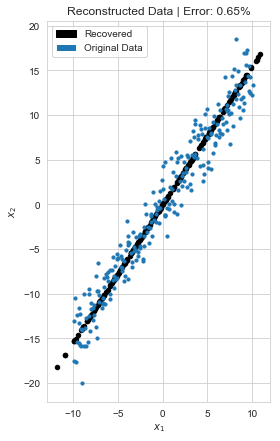

In [16]:
recovered_data = projection1D.dot(pc1.T).rename(columns={0: '$x_1$', 1: '$x_2$'})

rms_reconstruction_error = np.sqrt(np.mean(np.sum(np.square(recovered_data-data_), axis=1)))

rss_data = np.sqrt(np.sum(data_.values**2))

relative_loss = rms_reconstruction_error / rss_data

title='Reconstructed Data | Error: {:.2%}'.format(relative_loss)
ax = recovered_data.plot.scatter(x=0, y=1, title=title, c='k')
ax.set_aspect('equal')
data_.plot.scatter(x=0, y=1, s=10, ax=ax, figsize=(4,8))
plt.legend(handles=[Patch(color='k', label='Recovered'),  
                    Patch(label='Original Data')])
plt.tight_layout()

### Projection and inverse transformation lead to the same result

In [17]:
np.allclose(recovered_data, X_.dot(pc1) * pc1.T)

True